**Indiquer dans la boîte ci-dessous vos noms et prénoms**

Harb Hassan et Chrétien Clément 

# 3I026 - Intelligence artificielle & Data science

# TP 3 - Perceptron

L'objectif est d'implanter l'algorithme du perceptron de Rosenblatt, ainsi que quelques extensions, et d'évaluer leurs performances sur des données aléatoires puis réelles.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import copy
%matplotlib inline

## Rappels sur les TPs précédent

In [14]:
class LabeledSet:  
    
    def __init__(self, input_dimension):
        self.input_dimension = input_dimension
        self.nb_examples = 0
    
    def addExample(self, vector, label):
        if (self.nb_examples == 0):
            self.x = np.array([vector])
            self.y = np.array([label])
        else:
            self.x = np.vstack((self.x,vector))
            self.y = np.vstack((self.y,label))
        
        self.nb_examples = self.nb_examples + 1
    
    #Renvoie la dimension de l'espace d'entrée
    def getInputDimension(self):
        return self.input_dimension
        
    #Renvoie le nombre d'exemples dans le set
    def size(self):
        return self.nb_examples
    
    #Renvoie la valeur de x_i
    def getX(self, i):
        return self.x[i]
            
    #Renvoie la valeur de y_i
    def getY(self, i):
        return self.y[i]
    
    # Renvoie 2 labeledSet depuis 1 
    def split(self, pourcent):
        train = LabeledSet(self.input_dimension)
        test = LabeledSet(self.input_dimension)
        alea = [i for i in range(self.size())]
        random.shuffle(alea)
        for i in range(len(alea)):
            if i < pourcent * self.size() / 100:
                train.addExample(self.getX(alea[i]), self.getY(alea[i]))
            else:
                test.addExample(self.getX(alea[i]), self.getY(alea[i]))
        return train, test

In [4]:
class Classifier:
    def __init__(self, input_dimension):
        raise NotImplementedError("Please Implement this method")
    
    #Permet de calculer la prediction sur x => renvoie un score
    def predict(self, x):
        raise NotImplementedError("Please Implement this method")
    
    #Permet d'entrainer le modele sur un ensemble de données
    def train(self, labeledSet):
        raise NotImplementedError("Please Implement this method")
    
    #Permet de calculer la qualité du système 
    def accuracy(self, dataset):
        nb_ok = 0
        for i in range(dataset.size()):
            output = self.predict(dataset.getX(i))
            if (output * dataset.getY(i) > 0):
                nb_ok = nb_ok + 1
        acc = nb_ok / (dataset.size() * 1.0)
        return acc

In [5]:
class ClassifierRandom(Classifier):
    def __init__(self, dim):
        self.w = np.random.rand(dim)

    def predict(self, x):
        z = np.dot(x, self.w)
        if z > 0:
            return +1
        else:
            return -1

In [6]:
def plot_frontiere(set, classifier, step=20):
    mmax = set.x.max(0)
    mmin = set.x.min(0)
    x1grid, x2grid = np.meshgrid(np.linspace(mmin[0], mmax[0], step), np.linspace(mmin[1], mmax[1], step))
    grid = np.hstack((x1grid.reshape(x1grid.size, 1), x2grid.reshape(x2grid.size, 1)))
    
    # calcul de la prediction pour chaque point de la grille
    res = np.array([classifier.predict(grid[i,:]) for i in range(len(grid)) ])
    res = res.reshape(x1grid.shape)
    # tracé des frontieres
    plt.contourf(x1grid, x2grid, res, colors=["red", "cyan"], levels=[-1000,0,1000], linewidth=2)
    
#Renvoie les points du labeledSet et en fonction de leur couleur
def points(labeledSet):
    xr = []
    yr = []
    xb = []
    yb = []
    for i in range(labeledSet.size()):
        if labeledSet.getY(i) > 0:
            xr.append(labeledSet.getX(i)[0])
            yr.append(labeledSet.getX(i)[1])
        else:
            xb.append(labeledSet.getX(i)[0])
            yb.append(labeledSet.getX(i)[1])
    return xr, yr, xb, yb

## Étape 1 : Perceptron de Rosenblatt


En héritant de la classe `Classifier`, implanter le perceptron tel que décrit en cours. La fonction `train` fera une itération sur l'ensemble des données de l'apprentissage. Les points d'apprentissage seront tirés dans un ordre aléatoire.

In [22]:
class Perceptron(Classifier):
    
    def __init__(self, input_dimension, learning_rate, nombre_iterations):
        self.input_dimension = input_dimension
        self.learning_rate = learning_rate
        self.nombre_iterations = nombre_iterations
        self.w = np.random.rand(input_dimension) * 2 - 1
    
    def predict(self, x):
        return np.dot(x, self.w)
    
    def train(self, labeledSet):
        alea = [k for k in range(labeledSet.size())]
        random.shuffle(alea)
        for j in alea:
            if self.predict(labeledSet.getX(j))*labeledSet.getY(j) < 0:
                self.w = self.w + self.learning_rate * labeledSet.getY(j) * labeledSet.getX(j)
                
    def iterate(self, test, training):
        train_acc = []
        test_acc = []
        train_acc.append(self.accuracy(training))
        test_acc.append(self.accuracy(test))
        #print "Avant entrainement data training :", self.accuracy(training)
        #print "Avant entrainement data test :", self.accuracy(test)
        #print
        for i in range(self.nombre_iterations):
            old_w = copy.deepcopy(self.w)
            self.train(training)
            train_acc.append(self.accuracy(training))
            test_acc.append(self.accuracy(test))
            #print self.accuracy(training)
            #print self.accuracy(test)
            #print
            if np.array_equal(old_w, self.w):
                #print "Converge"
                break
        #print "Apres entrainement data training :", self.accuracy(training)
        #print "Apres entrainement data test :", self.accuracy(test)
        return test_acc, train_acc                     

La méthode `train` devra faire un nombre d'itérations fixées à la création de l'objet.

Pour pouvoir évaluer la qualité de l'apprentissage au cours des itérations, on évaluera régulièrement (par exemple toutes les 10 itérations) l'accuracy du modèle, sur un ensemble de validation (un sous-ensemble de l'ensemble d'apprentissage). 

Après chaque apprentissage, on veillera à tracer la courbe d'apprentissage, c'est à dire le score obtenu au cours des itérations, et à tracer la frontière de décision.

Tester votre code sur des données aléatoires.

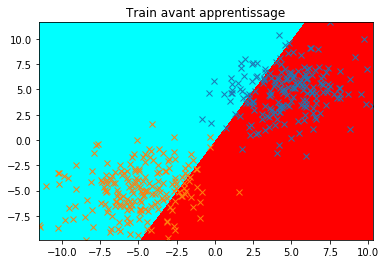

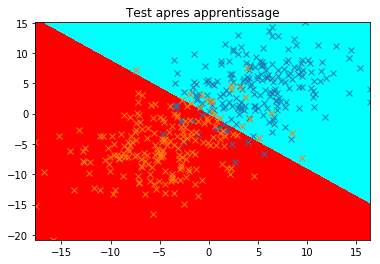

In [41]:
# Test du perceptron sur 2 nuages de points qui ne se mélange pas sur les données d'apprentissage et
# un petit peu sur les données de test.

# Création des deux gaussiennes 
mean1 = [5, 5]
mean2 = [-5, -5]
cov = [[5, 1], [1, 5]]  # diagonal covariance
cov2 = [[20, 5], [5, 20]]  # diagonal covariance
mat1 = np.random.multivariate_normal(mean1, cov, 200).T
mat2 = np.random.multivariate_normal(mean2, cov, 200).T
mat3 = np.random.multivariate_normal(mean1, cov2, 200).T
mat4 = np.random.multivariate_normal(mean2, cov2, 200).T


# Création du LabeledSet et affichage 
training_data = LabeledSet(2)
test_data = LabeledSet(2)
for i in range(len(mat1[0])):
    training_data.addExample([mat1[0][i], mat1[1][i]], 1)
    test_data .addExample([mat3[0][i], mat3[1][i]], 1)
for i in range(len(mat2[0])):
    training_data.addExample([mat2[0][i], mat2[1][i]], -1)
    test_data .addExample([mat4[0][i], mat4[1][i]], -1)
    

# Création du perceptron
perceptron = Perceptron(2, 0.001, 1000)


# Affichage avant apprentissage
plt.plot(mat1[0], mat1[1], 'x')
plt.plot(mat2[0], mat2[1], 'x')
plt.title("Train avant apprentissage")
plot_frontiere(training_data, perceptron)
plt.show()


# Apprentissage
perceptron.iterate(test_data, training_data)


# Affichage après apprentissage
plot_frontiere(test_data, perceptron)
plt.plot(mat3[0], mat3[1], 'x')
plt.plot(mat4[0], mat4[1], 'x')
plt.title("Test apres apprentissage")
plt.show()

**Questions**

- Comment choisir le nombre d'itérations ?
<br>Il faut faire le plus d'itération possible jusqu'à avoir une convergence ou si cela est trop long s'arrêter avant. 

- Quelle est l'influence du paramètre `learning_rate` ?
<br>Learning_rate détermine à quel point le vecteur w va s'ajuster lorsqu'il se trompe pour un point. 

- Que se passe-t-il si le nombre d'exemple d'apprentissage est faible ?
<br>Si le nombre d'apprentissage est faible le vecteur w trouvé aura de mauvais résultat avec les données de test. 

## Étape 2: Données XOR

Générer une base de données, appelée XOR par la suite, contenant:
- deux gaussiennes centrées en (0,0) et (1,1) correspondant à des exemples positifs
- deux gaussiennes centrées en (1,0) et (0,1) correspondant à des exemples négatifs

Boite provenant d'une mauvaise compréhension de l'énoncé. 
Les données de test et de training sont inversées (en test, croix bleu en haut et rouge en bas, inverse pour le training) ce qui n'a pas beaucoup de sens.  

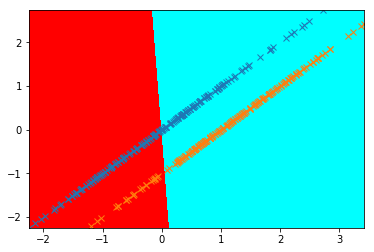

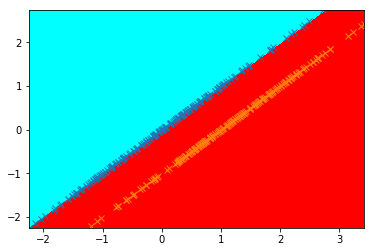

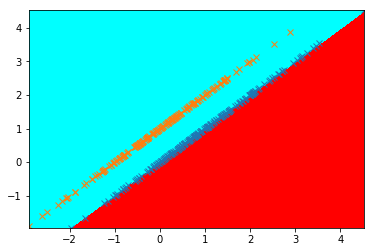

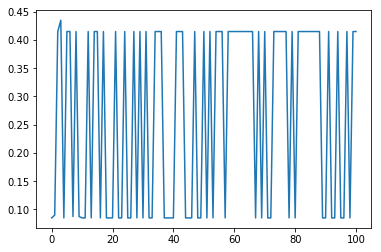

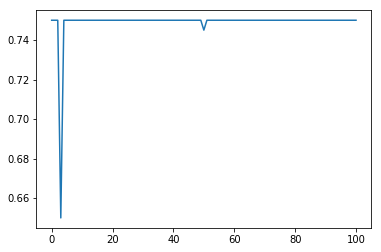

In [12]:
mean1 = [0, 0]
mean2 = [1, 1]
mean3 = [1, 0]
mean4 = [0, 1]
cov = [[1, 1], [1, 1]]  # diagonal covariance
mat1 = np.random.multivariate_normal(mean1, cov, 200).T
mat2 = np.random.multivariate_normal(mean2, cov, 200).T
mat3 = np.random.multivariate_normal(mean3, cov, 200).T
mat4 = np.random.multivariate_normal(mean4, cov, 200).T
training_data = LabeledSet(2)
test_data = LabeledSet(2)
for i in range(len(mat1[0])):
    training_data.addExample([mat1[0][i], mat1[1][i]], 1)
    test_data .addExample([mat2[0][i], mat2[1][i]], 1)
for i in range(len(mat2[0])):
    training_data.addExample([mat3[0][i], mat3[1][i]], -1)
    test_data .addExample([mat4[0][i], mat4[1][i]], -1)
plt.plot(mat1[0], mat1[1], 'x')
plt.plot(mat3[0], mat3[1], 'x')
plot_frontiere(training_data, perceptron)
plt.show()
perceptron = Perceptron(2, 0.3, 100)
a, b = perceptron.iterate(test_data, training_data)
plt.plot(mat1[0], mat1[1], 'x')
plt.plot(mat3[0], mat3[1], 'x')
plot_frontiere(training_data, perceptron)
plt.show()
plt.plot(mat2[0], mat2[1], 'x')
plt.plot(mat4[0], mat4[1], 'x')
plot_frontiere(test_data, perceptron)
plt.show()
nb_ite = [i for i in range(101)]
plt.plot(nb_ite, a)
plt.show()
plt.plot(nb_ite, b)
plt.show()


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:10: RuntimeWarning: covariance is not positive-semidefinite.
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:11: RuntimeWarning: covariance is not positive-semidefinite.
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:12: RuntimeWarning: covariance is not positive-semidefinite.
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:13: RuntimeWarning: covariance is not positive-semidefinite.


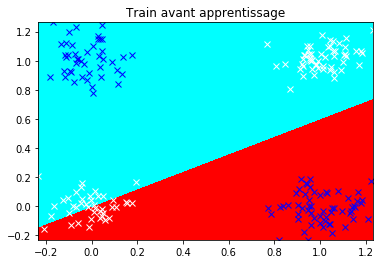

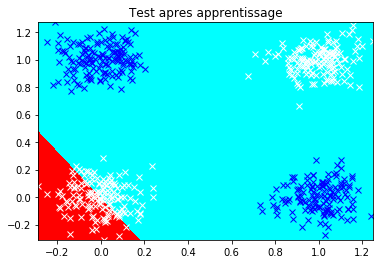

In [42]:
# XOR avec les même données divisées en deux parties (méthode split), on remarque que le perceptron ne peut pas trouver une 
# droite pouvant séparer les +1 des -1 


# Création des données 
mean1 = [0, 0]
mean2 = [1, 1]
mean3 = [1, 0]
mean4 = [0, 1]
mat1 = np.random.multivariate_normal(mean1, [[0,0.01],[0.01,0]], 200).T
mat2 = np.random.multivariate_normal(mean2, [[0,0.01],[0.01,0]], 200).T
mat3 = np.random.multivariate_normal(mean3, [[0,0.01],[0.01,0]], 200).T
mat4 = np.random.multivariate_normal(mean4, [[0,0.01],[0.01,0]], 200).T


# Création du LabeledSet
data = LabeledSet(2)
for i in range(len(mat1[0])):
    data.addExample([mat1[0][i], mat1[1][i]], 1)
    data .addExample([mat2[0][i], mat2[1][i]], 1)
for i in range(len(mat2[0])):
    data.addExample([mat3[0][i], mat3[1][i]], -1)
    data .addExample([mat4[0][i], mat4[1][i]], -1)


# Création du perceptron
perceptron = Perceptron(2, 0.5, 100)
data_training, data_test = data.split(25) # On split les données 
xra, yra, xba, yba = points(data_training) # Utilisé pour affichage 
xrb, yrb, xbb, ybb = points(data_test) # (obligatoire si le même jeu de donnée est utilisée pour le train et les tests)


# Affichage avant apprentissage
plt.plot(xra, yra, 'wx')
plt.plot(xba, yba, 'bx')
plt.title("Train avant apprentissage")
plot_frontiere(data_training, perceptron)
plt.show()


# Apprentissage
a, b = perceptron.iterate(data_test, data_training)


# Affichage après apprentissage
plt.plot(xrb, yrb, 'wx')
plt.plot(xbb, ybb, 'bx')
plt.title("Test apres apprentissage")
plot_frontiere(data_test, perceptron)
plt.show()


**Questions**
- Que se passe-t-il quand on apprend un perceptron ?
<br> Etant donné que le perceptron ne peut pas trouver un vecteur w satisfaisant, celui ci va être modifié sans cesse et ne pourra pas s'améliorer au fil des itérations. 
- Quel est le problème ?
<br> Le perceptron ne peut pas trouver un vecteur w satisfaisant car c'est un classifieur linéaire et avec ces 4 nuages de points on ne peut pas trouver une droite les séparants. 

## Étape 4: Protocole expérimental

Attention, lorsque vous testez un classifieur, il est nécessaire de considérer à la fois un ensemble d'apprentissage et un ensemble de test. La performance doit être évaluée sur l'ensemble de test (et non pas sur l'ensemble d'apprentissage).

Évaluer les performances du perceptron selon différentes valeurs des hyper-paramètres (*learning rate*, nombre d'itérations), tracer les courbes d'apprentissage et les frontières de décisions. Commenter.

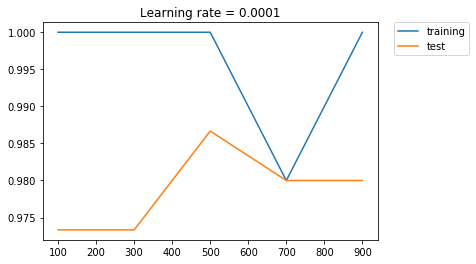

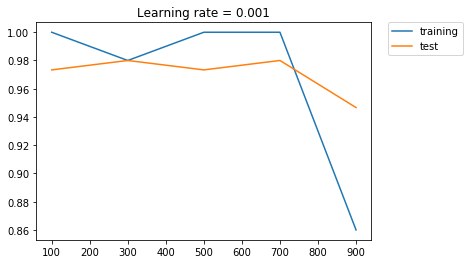

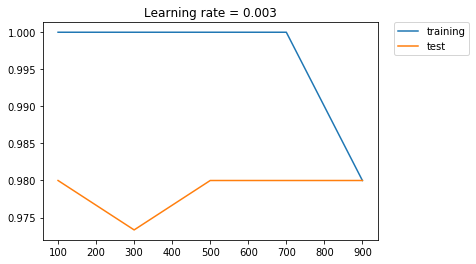

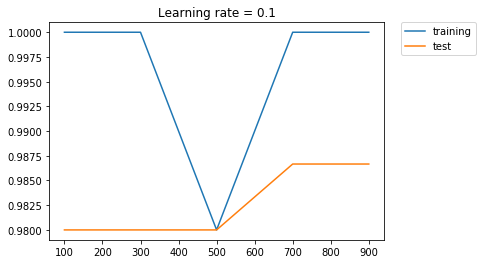

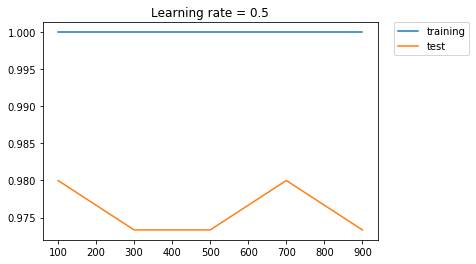

In [40]:
# Attendre environ 30 secondes pour que les graphiques apparaissent, faire attention à l'axe y pour la précision.


# Initialisation des données
mean1 = [5, 5]
mean2 = [-5, -5]
cov = [[7, 2], [2, 7]]  # diagonal covariance
cov2 = [[7, 2], [2, 7]]  # diagonal covariance
mat1 = np.random.multivariate_normal(mean1, cov, 100).T
mat2 = np.random.multivariate_normal(mean2, cov2, 100).T


# Initialisation du labeledSet
data = LabeledSet(2)
for i in range(len(mat1[0])):
    data.addExample([mat1[0][i], mat1[1][i]], 1)
for i in range(len(mat2[0])):
    data.addExample([mat2[0][i], mat2[1][i]], -1)
data_train, data_test = data.split(25) # 25% des données sont utilisées pour apprendre, le reste pour les prédictions. 


# Affichage de l'accuracy en fonction du learning rate et du nombre d'itérations
pallier = [i for i in range(100, 1001, 200)] # nombre d'itérations
lr = [0.0001, 0.001, 0.003, 0.1, 0.5] # learning rate
for n in range(len(pallier)):
    acc_train = []
    acc_test = []
    for i in pallier:
        perceptron = Perceptron(2, lr[n], i)
        a, b = perceptron.iterate(data_train, data_test)
        acc_train.append(a[len(a)-1])
        acc_test.append(b[len(b)-1])
    plt.plot(pallier, acc_train, label="training")
    plt.plot(pallier, acc_test, label="test")
    plt.title("Learning rate = " + str(lr[n]))
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()



Tracer des courbes indiquant les performances en fonction des hyper-paramètres. Commenter.

## Étape 5 : données réelles UCI

In [9]:
from sklearn.datasets import fetch_mldata

def loadFile(name):
    data = fetch_mldata(name, data_home='.')
    print(data.data.shape)
    unique=np.unique(data.target)
    for i in range(len(data.target)):
        if (data.target[i]==unique[0]):
            data.target[i]=1
        else:
            data.target[i]=-1
            
loadFile('breast-cancer_scale')
#Les donnees sont dans data.data et data.target

(683, 10)


Sur ces données réelles, évaluer les performances du perceptron, selon la valeur des hyper-paramètres et comparer aux performances de $k$-NN (avec plusieurs valeurs de $k$. Réfléchir à une façon de choisir la meilleur valeur des hyper-paramètres.